In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
USE_CUDA = torch.cuda.is_available() 
device = torch.device("cuda" if USE_CUDA else "cpu") 
print("device", device)
batch_size = 24
hidden_size = 10
input_size = 2
output_size = 1

class Custom_Activation_F:
    
    def __init__(self, rate = 1):
        self.rate = rate
        
    def logact(self, a):
        '''
        logistic activation function
        '''
        i = 0
        while i < len(a):
            j = 0
            while j < len(a[i]):
                if a[i][j] > 0:
                    a[i][j] = torch.log(a[i][j] + self.rate)
                else:
                    a[i][j] = - torch.log(self.rate - a[i][j])
                j = j + 1
            i = i + 1
        return a
 

device cpu


In [2]:
class BayesianLinear(nn.Module):
    
    def __init__(self, i_s, o_s):
        '''
        i_s = input_size
        o_s = output_size
        
        '''
        super().__init__()
        self.i_s = i_s
        self.o_s = o_s
        self.b_s = 1
        self.w = nn.Parameter(
            torch.zeros(self.i_s, self.o_s, dtype = torch.float32, requires_grad=True)
        )
        self.b = nn.Parameter(
            torch.zeros(self.o_s, dtype = torch.float32, requires_grad=True)
        )
        
        self.w_prior = torch.zeros(self.i_s, self.o_s)
        self.b_prior = torch.zeros(self.o_s)
        
    def _rep(self, mu):
        return mu + torch.randn_like(mu)*0.1
    
    def _update_prior(self, w1, w2, b, rate = 0.1):
        self.w_prior = w.clone().detach()*rate + self.w_prior*(1-rate)
        self.b_prior = b.clone().detach()*rate + self.b_prior*(1-rate)
        
    def kldloss(self):
        sum1 = torch.sum(torch.square(self.w - self.w_prior))
        sum2 = torch.sum(torch.square(self.b - self.b_prior))
        return sum1 + sum2
    
    def forward(self, x):
        self.b_s = len(x)
        b = self._rep(self.b)
        w = self._rep(self.w)
        b = b.expand(self.b_s, self.o_s)
        x = torch.matmul(x, w) + b
        #self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    

In [3]:
class Bayesian_Regress(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.tanh = nn.Tanh()
        self.lrelu = nn.LeakyReLU(0.1)
        self.blinear1 = BayesianLinear(input_size, hidden_size)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size)
        self.blinear3 = BayesianLinear(hidden_size, output_size)
        self.myact = Custom_Activation_F()
    
    def forward(self, x):
        x = self.blinear1(x)
        x = self.myact.logact(x)
        x = self.blinear2(x)
        x = self.myact.logact(x)
        x = self.blinear3(x)
        
        #self._update_prior(self.w1_prior, self.w2_prior, self.b_prior, rate)
        #if we want to move prior, we can just subtract _prior term at the upper line
        return x
    
    def kld_loss(self):
        
        L1 = self.blinear1.kldloss()
        L2 = self.blinear2.kldloss()
        L3 = self.blinear3.kldloss()
        
        return (L1+L2+L3)

In [4]:
regressor = Bayesian_Regress(2, 10, 1)

In [5]:
tmp_data = torch.tensor([[-1., 3., 5], [-2, 2, 5], [-0.5, 2, 4], 
                         [-0.5, 1.5, 3], [0.5, 1, 1], [1, 1, -1],
                         [2, 2, -3], [3, 2, -4], [4, 4, -5],
                         [5, 4, -4], [5, 5, -3], [6, 4, -2],
                         [7, 4, -1], [8, 3, 0], [8, 4, 1],
                         [9, 3, 3], [9, 1, 5], [10, 2, 6], 
                         [11, 3, 3], [13, 3, 1], [15, 1, -1], 
                         [-3, 1, 3], [40, 3, -5], [40, 3, -5]])



train_dataloader = DataLoader(tmp_data, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.SGD(regressor.parameters(), lr=0.001)




In [6]:
i = 0
batch_size = 24
total_num = 24

while i < 1000:
    train_data = next(iter(train_dataloader))
    input_data, target = torch.split(train_data, [input_size, output_size], dim = 1)
    output = regressor(input_data)
    total_loss = (torch.sum(torch.square(target - output)) + 
                  regressor.kld_loss()*(1/total_num)
                 )
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(total_loss)
    i = i + 1

tensor(296.0341, grad_fn=<AddBackward0>)
tensor(244.6880, grad_fn=<AddBackward0>)
tensor(227.0694, grad_fn=<AddBackward0>)
tensor(223.1400, grad_fn=<AddBackward0>)
tensor(220.8584, grad_fn=<AddBackward0>)
tensor(176.3153, grad_fn=<AddBackward0>)
tensor(154.4033, grad_fn=<AddBackward0>)
tensor(123.1114, grad_fn=<AddBackward0>)
tensor(113.6553, grad_fn=<AddBackward0>)
tensor(131.7549, grad_fn=<AddBackward0>)


/var/folders/8_/4r7bgqsn54q6km29ph3gjqwc0000gn/T/ipykernel_19857/34118948.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z9 = torch.tensor(z, requires_grad = False).numpy()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


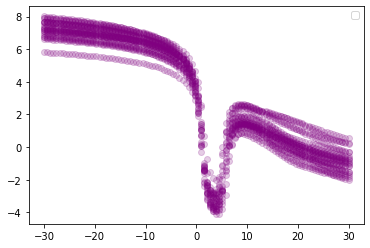

In [8]:
x = np.linspace(-30, 30, 100)
y = np.linspace(3, 3, 100)
newxy = np.concatenate((np.transpose([x]), np.transpose([y])), axis = 1)
newxy = torch.tensor(newxy, dtype = torch.float32)
newxy = torch.reshape(newxy,(100,2))


i = 0
while i<20:
    z = regressor(newxy)
    Z9 = torch.tensor(z, requires_grad = False).numpy()
    plt.scatter(x, Z9, color = 'purple', alpha = 0.2)
    i = i + 1

plt.legend()
plt.show()